In [109]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import rcParams

%matplotlib inline
from scipy.stats import skew
from scipy.stats import boxcox
from scipy.stats import pearsonr

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.externals.joblib import dump
from sklearn.externals.joblib import load
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# DATA PREPROCESSING


In [116]:
red_df=pd.read_csv("winequality-red.csv",sep=";")
white_df=pd.read_csv("winequality-white.csv", sep=";")
color_red = np.repeat("red", red_df.shape[0])
color_white = np.repeat("white", white_df.shape[0])
red_df.insert(loc=0,column="type",value=color_red)
white_df.insert(loc=0,column="type",value=color_white)
wine_df=red_df.append(white_df)
replace_list = {"type" : {"red": 1, "white" : 0,}}
wine_df.replace(replace_list,inplace=True)



In [117]:
wine_df.head(5)


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,1,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,1,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,1,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# exploratory data analysis

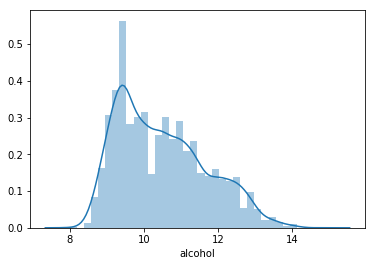

In [110]:
sns.distplot(wine_df["alcohol"],)
plt.show()

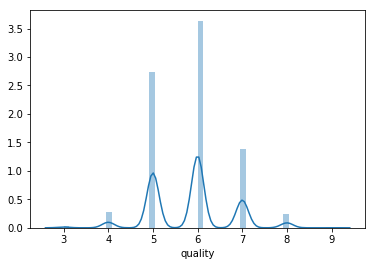

In [111]:
sns.distplot(wine_df["quality"],)
plt.show()

In [60]:
# Set figure width to 16 and height to 12 (4:3 aspect ratio)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

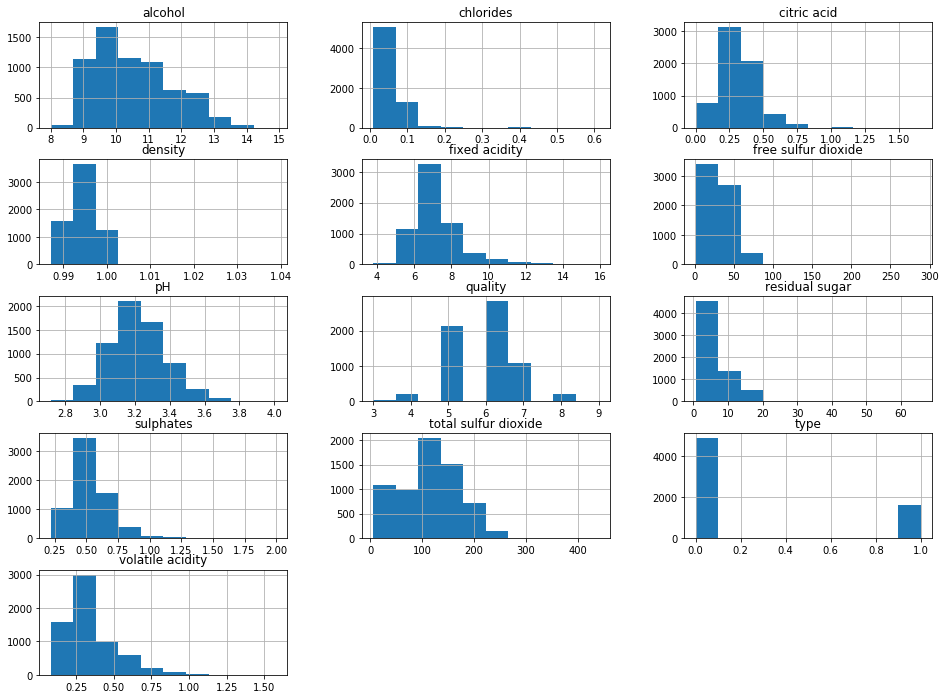

In [61]:

# Histograms for each attribute

wine_df.hist(layout=(5,3))
plt.show()

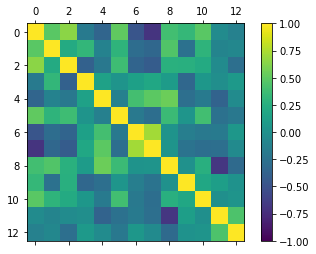

In [7]:
# Correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(wine_df.corr(), vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

## feature selection

In [8]:
X=wine_df.drop(columns="type",axis=1).values
y=wine_df.iloc[:, 0].values




## split-out training dataset

In [65]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42)
sc = StandardScaler()
X_train= sc.fit_transform(X_train)
X_test = sc.transform(X_test)


## test option and evaluating model

In [120]:
# Set up Algorithms Spot-Checking Array
num_folds = 10
scoring = 'accuracy'
seedNum = 42
models = []
models.append(('LOGREG', LogisticRegression()))
models.append(('CART', DecisionTreeClassifier(random_state=seedNum)))
models.append(('NB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC(random_state=seedNum)))
models.append(('LDA', LinearDiscriminantAnalysis()))
results = []
names = []
metrics = []

In [121]:
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seedNum)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    metrics.append(cv_results.mean())
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
print ('Average metrics ('+scoring+') from all models:',np.mean(metrics))

LOGREG: 0.994035 (0.002349)
CART: 0.984029 (0.004717)
NB: 0.975948 (0.007107)
KNN: 0.994034 (0.003597)
SVM: 0.996730 (0.002283)
LDA: 0.995190 (0.002470)
Average metrics (accuracy) from all models: 0.989994256707


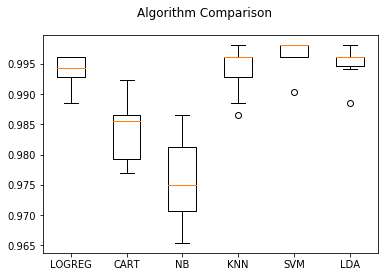

In [122]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## model tuning for kneighbour classifier

In [68]:

k_range = list(range(1, 20))
param_grid = dict(n_neighbors=k_range)
knn = KNeighborsClassifier(n_neighbors=5)
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

In [69]:
# fit the grid with data
grid.fit(X_train, y_train)


GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [70]:
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.994612 using {'n_neighbors': 2}
0.994420 (0.002348) with: {'n_neighbors': 1}
0.994612 (0.003194) with: {'n_neighbors': 2}
0.993458 (0.002876) with: {'n_neighbors': 3}
0.994420 (0.003380) with: {'n_neighbors': 4}
0.994227 (0.003440) with: {'n_neighbors': 5}
0.994035 (0.003792) with: {'n_neighbors': 6}
0.994035 (0.003153) with: {'n_neighbors': 7}
0.994035 (0.003792) with: {'n_neighbors': 8}
0.994227 (0.003748) with: {'n_neighbors': 9}
0.994227 (0.004124) with: {'n_neighbors': 10}
0.993843 (0.003728) with: {'n_neighbors': 11}
0.993650 (0.004038) with: {'n_neighbors': 12}
0.993650 (0.004217) with: {'n_neighbors': 13}
0.994035 (0.004164) with: {'n_neighbors': 14}
0.993843 (0.004195) with: {'n_neighbors': 15}
0.993843 (0.004014) with: {'n_neighbors': 16}
0.993458 (0.003566) with: {'n_neighbors': 17}
0.993650 (0.003945) with: {'n_neighbors': 18}
0.993650 (0.003653) with: {'n_neighbors': 19}


In [129]:
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]



Text(0,0.5,'Cross-Validated Accuracy')

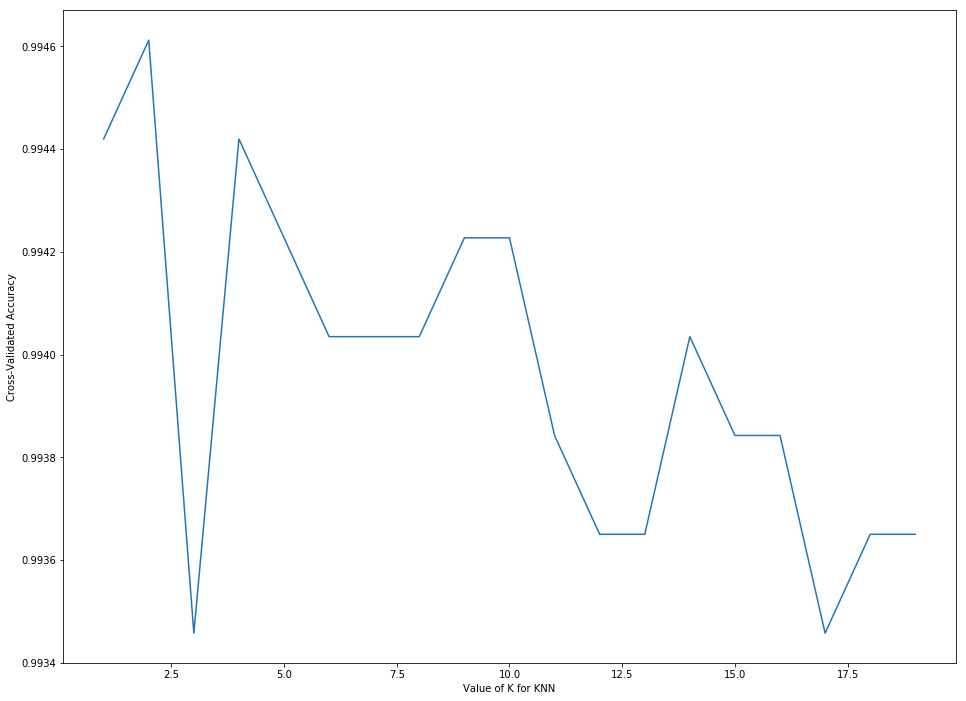

In [72]:
# plot the results
# this is identical to the one we generated above
plt.plot(k_range, grid_mean_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [73]:
knn= KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
pred_knn = knn.predict(X_test)
print(classification_report(y_test, pred_knn))
print(confusion_matrix(y_test,pred_knn))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99       959
          1       0.99      0.97      0.98       341

avg / total       0.99      0.99      0.99      1300

[[957   2]
 [  9 332]]


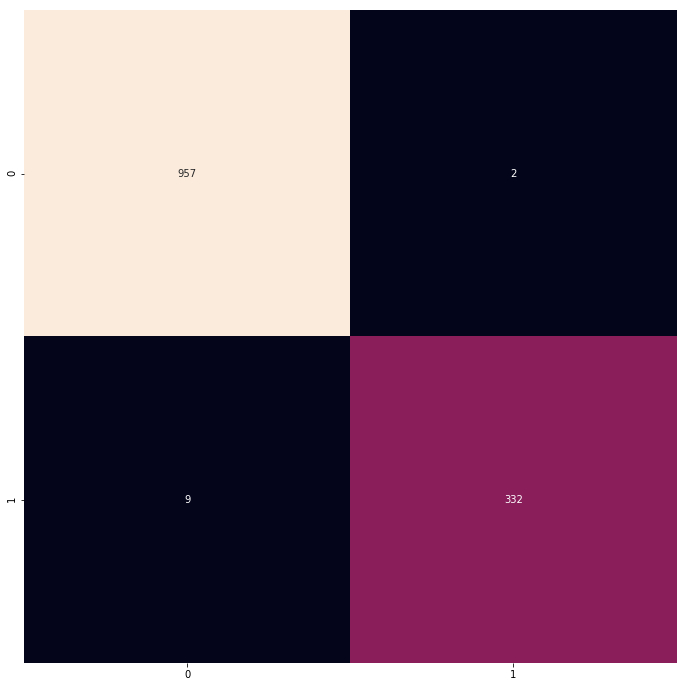

In [74]:
sns.heatmap(confusion_matrix(y_test,pred_knn),annot=True,square=True,cbar=False,fmt="d")

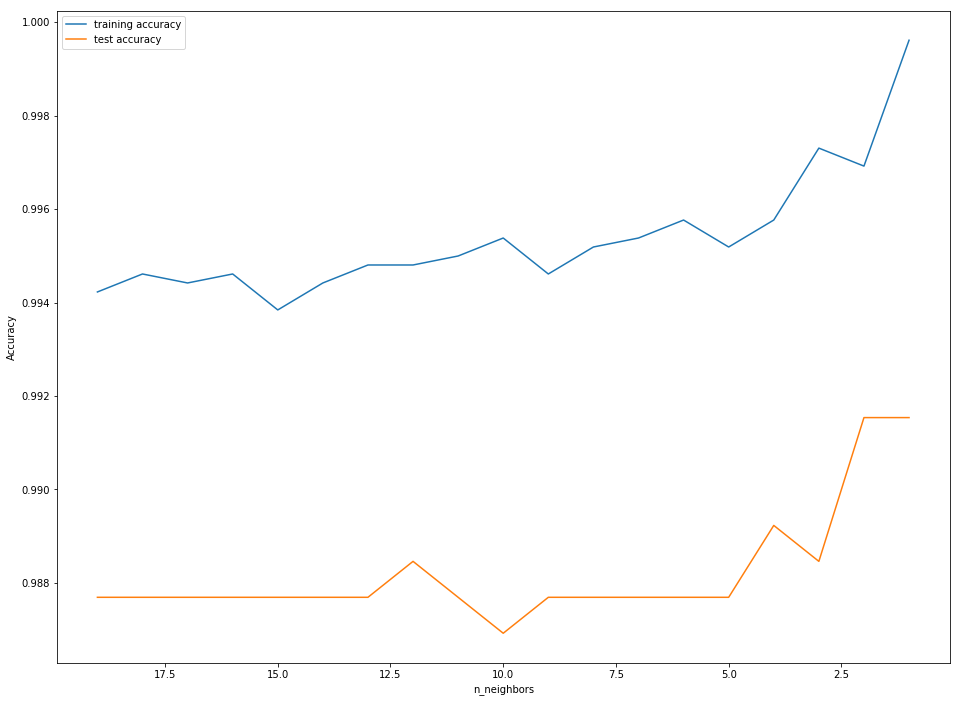

In [75]:
training_accuracy = []
test_accuracy = []

neighbors_settings = list(range(1, 6))
for n_neighbors in neighbors_settings:
# build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
# record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
# record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.gca().invert_xaxis()
plt.legend()

## model parameter tunung for SVC

In [130]:
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid1 = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid1, cv=10)
grid_search.fit(X_train, y_train)



GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [131]:
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means1 = grid_search.cv_results_['mean_test_score']
stds1 = grid_search.cv_results_['std_test_score']
params1 = grid_search.cv_results_['params']
for mean1, stdev1, param1 in zip(means1, stds1, params1):
    print("%f (%f) with: %r" % (mean1, stdev1, param1))

Best: 0.996536 using {'C': 10, 'gamma': 0.01}
0.757937 (0.000502) with: {'C': 0.001, 'gamma': 0.001}
0.757937 (0.000502) with: {'C': 0.001, 'gamma': 0.01}
0.757937 (0.000502) with: {'C': 0.001, 'gamma': 0.1}
0.757937 (0.000502) with: {'C': 0.001, 'gamma': 1}
0.757937 (0.000502) with: {'C': 0.01, 'gamma': 0.001}
0.970175 (0.005649) with: {'C': 0.01, 'gamma': 0.01}
0.976910 (0.008191) with: {'C': 0.01, 'gamma': 0.1}
0.757937 (0.000502) with: {'C': 0.01, 'gamma': 1}
0.976140 (0.006454) with: {'C': 0.1, 'gamma': 0.001}
0.992303 (0.002851) with: {'C': 0.1, 'gamma': 0.01}
0.993265 (0.003672) with: {'C': 0.1, 'gamma': 0.1}
0.789494 (0.004955) with: {'C': 0.1, 'gamma': 1}
0.992303 (0.002433) with: {'C': 1, 'gamma': 0.001}
0.995574 (0.002285) with: {'C': 1, 'gamma': 0.01}
0.996344 (0.002007) with: {'C': 1, 'gamma': 0.1}
0.949971 (0.009277) with: {'C': 1, 'gamma': 1}
0.994612 (0.002693) with: {'C': 10, 'gamma': 0.001}
0.996536 (0.002403) with: {'C': 10, 'gamma': 0.01}
0.996536 (0.002071) with: {

In [78]:
svc = SVC(C=10,gamma=0.01)
svc.fit(X_train, y_train)
pred_svc = svc.predict(X_test)
print(classification_report(y_test, pred_svc))
print(confusion_matrix(y_test,pred_svc))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00       959
          1       1.00      0.99      0.99       341

avg / total       1.00      1.00      1.00      1300

[[958   1]
 [  5 336]]


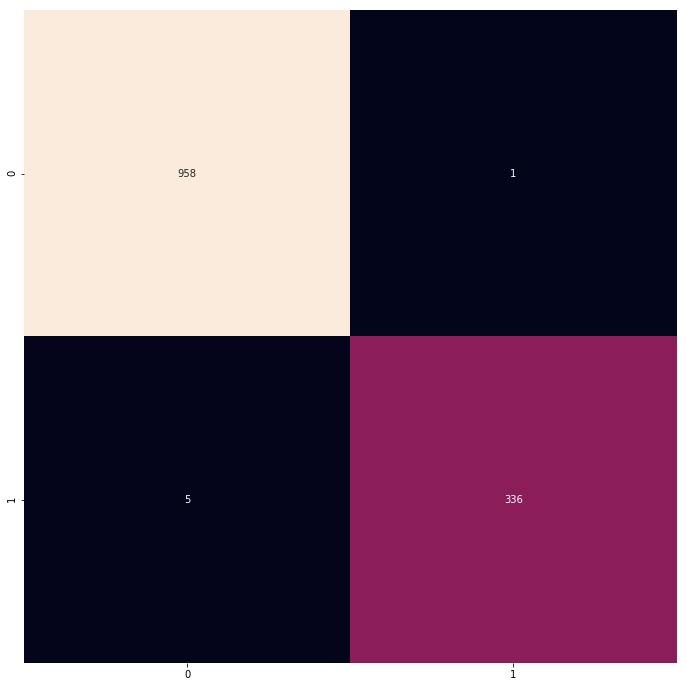

In [79]:
sns.heatmap(confusion_matrix(y_test,pred_svc),annot=True,square=True,cbar=False,fmt="d")

# multiclass classification

## feature selection

In [80]:
x_mul=wine_df.drop(columns="quality",axis=1).values
y_mul= wine_df['quality'].values

## train test split

In [82]:
validation_size = 0.30
X_train1, X_validation, Y_train1, Y_validation = train_test_split(x_mul, y_mul, test_size=validation_size, random_state=42)

## Model and Evaluate Algorithms

In [142]:
# Set up Algorithms Spot-Checking Array
num_folds1 = 10
scoring1 = 'accuracy'
seedNum1 = 42
models1 = []
models1.append(('KNN', KNeighborsClassifier()))
models1.append(('SVM', SVC(random_state=seedNum)))
models1.append(('BDT', BaggingClassifier(random_state=seedNum)))
models1.append(('RF', RandomForestClassifier(random_state=seedNum)))
models1.append(('ET', ExtraTreesClassifier(random_state=seedNum)))
results1 = []
names1 = []
metrics1 = []


In [144]:

for name1, model1 in models1:
    kfold = KFold(n_splits=num_folds, random_state=seedNum)
    cv_results1 = cross_val_score(model1, X_train1, Y_train1, cv=kfold, scoring=scoring)
    results1.append(cv_results1)
    names1.append(name1)
    metrics1.append(cv_results1.mean())
    msg1 = "%s: %f " % (name1, cv_results1.mean())
    print(msg1)
print ('Average metrics ('+scoring+') from all models:',np.mean(metrics1))

KNN: 0.474823 
SVM: 0.542989 
BDT: 0.623059 
RF: 0.632503 
ET: 0.643288 
Average metrics (accuracy) from all models: 0.583332332865


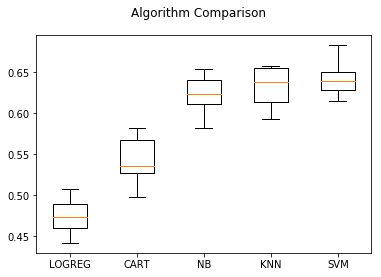

In [145]:

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results1)
ax.set_xticklabels(names)
plt.show()

## Random forest classifier

In [88]:
# Tuning algorithm  - Random Forest
# Set up the comparison array
results = []
names = []
paramGrid2 = dict(n_estimators=np.array([200,400,600,800,900]))
model2 = RandomForestClassifier(random_state=seedNum)
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid2 = GridSearchCV(estimator=model2, param_grid=paramGrid2, scoring=scoring, cv=kfold)
grid_result2 = grid2.fit(X_train1, Y_train1)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
results.append(grid_result2.cv_results_['mean_test_score'])
names.append('RF')
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))

Best: 0.672971 using {'n_estimators': 600}
0.668793 (0.021993) with: {'n_estimators': 200}
0.671432 (0.021187) with: {'n_estimators': 400}
0.672971 (0.022987) with: {'n_estimators': 600}
0.671872 (0.022380) with: {'n_estimators': 800}
0.671432 (0.020675) with: {'n_estimators': 900}
Model training time: 0:03:36.886010


Text(0,0.5,'RF Accuracy')

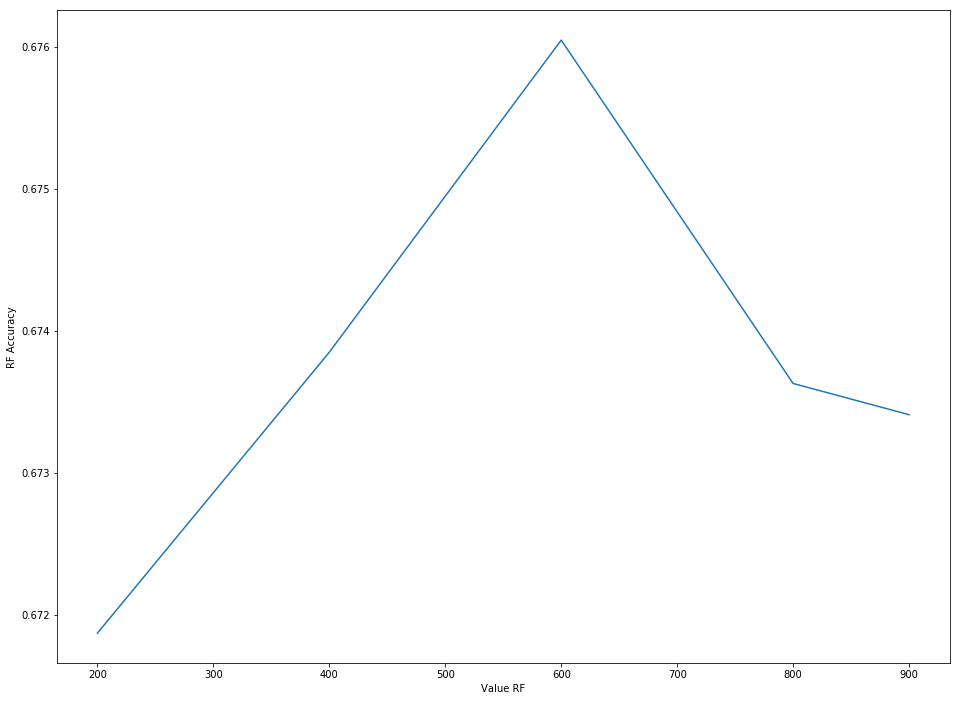

In [105]:

# plot the results
# this is identical to the one we generated above
xx=[200,400,600,800,900]
plt.plot(xx, means)
plt.xlabel('Value RF')
plt.ylabel('RF Accuracy')



In [113]:
model = RandomForestClassifier(n_estimators=600, random_state=seedNum)
model.fit(X_train1, Y_train1)
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.674358974359
[[  0   0   3   6   0   0   0]
 [  1   8  41  19   0   0   0]
 [  0   1 452 154   6   0   0]
 [  0   1 162 670  60   1   0]
 [  0   0   2 142 170   1   0]
 [  0   0   0  18  16  15   0]
 [  0   0   0   1   0   0   0]]
             precision    recall  f1-score   support

          3       0.00      0.00      0.00         9
          4       0.80      0.12      0.20        69
          5       0.68      0.74      0.71       613
          6       0.66      0.75      0.70       894
          7       0.67      0.54      0.60       315
          8       0.88      0.31      0.45        49
          9       0.00      0.00      0.00         1

avg / total       0.68      0.67      0.66      1950



## extra tree classifier

In [90]:
# - Extra Trees
paramGrid3 = dict(n_estimators=np.array([200,300,400,500,600]))
model3 = ExtraTreesClassifier(random_state=seedNum)
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid3 = GridSearchCV(estimator=model3, param_grid=paramGrid3, scoring=scoring, cv=kfold)
grid_result3 = grid3.fit(X_train1, Y_train1)

print("Best: %f using %s" % (grid_result3.best_score_, grid_result3.best_params_))
results.append(grid_result3.cv_results_['mean_test_score'])
names.append('ET')
means = grid_result3.cv_results_['mean_test_score']
stds = grid_result3.cv_results_['std_test_score']
params = grid_result3.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.676050 using {'n_estimators': 400}
0.671872 (0.023252) with: {'n_estimators': 200}
0.673851 (0.022338) with: {'n_estimators': 300}
0.676050 (0.021130) with: {'n_estimators': 400}
0.673631 (0.023009) with: {'n_estimators': 500}
0.673411 (0.023509) with: {'n_estimators': 600}


Text(0,0.5,'ET Accuracy')

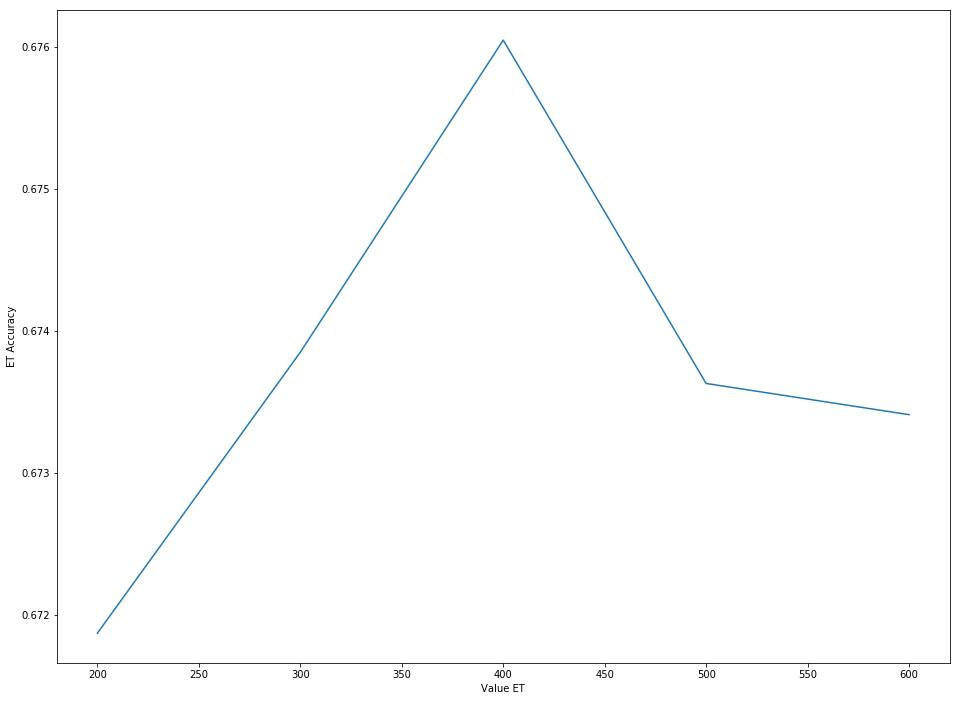

In [104]:

# plot the results
# this is identical to the one we generated above
xx=[200,300,400,500,600]
plt.plot(xx, means)
plt.xlabel('Value ET')
plt.ylabel('ET Accuracy')


In [108]:

model = ExtraTreesClassifier(n_estimators=400, random_state=seedNum)
model.fit(X_train1, Y_train1)
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.671282051282
[[  0   0   6   3   0   0   0]
 [  2  12  39  16   0   0   0]
 [  0   5 447 154   7   0   0]
 [  0   2 170 668  53   1   0]
 [  0   0   2 146 166   1   0]
 [  0   0   0  16  17  16   0]
 [  0   0   0   1   0   0   0]]
             precision    recall  f1-score   support

          3       0.00      0.00      0.00         9
          4       0.63      0.17      0.27        69
          5       0.67      0.73      0.70       613
          6       0.67      0.75      0.70       894
          7       0.68      0.53      0.59       315
          8       0.89      0.33      0.48        49
          9       0.00      0.00      0.00         1

avg / total       0.67      0.67      0.66      1950

